
# Assignment 3

This is a template notebook for Assignment 3.


## Install dependencies and initialization

In [ ]:
'''
# The next 8 lines added to be compatible with version changes (2022/10/13).
# change cuda to 11.1
!sudo apt-get update
!sudo apt-get install python3.9
!sudo apt-get install python3.9-distutils
!sudo update-alternatives --install /usr/bin/python3 python3 /usr/bin/python3.9 1
!sudo update-alternatives --config python3
#!sudo apt-get install pip
!sudo apt install python3-pip
!python3 --version

import os
p = os.getenv('PATH')
ld = os.getenv('LD_LIBRARY_PATH')
os.environ['PATH'] = f"/usr/local/cuda-11.1/bin:{p}"
os.environ['LD_LIBRARY_PATH'] = f"/usr/local/cuda-11.1/lib64:{ld}"
# change pytorch to 1.9.0 compiled with cuda 11.1
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 -f https://download.pytorch.org/whl/torch_stable.html


# install dependencies:
!pip install pyyaml==5.1 pycocotools>=2.0.1
# !pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/torch1.6/index.html
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu111/torch1.9/index.html
'''
!python3 --version
!pip install pyyaml
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))
print("finish")

In [ ]:
!pwd # shows current directory
!ls  # shows all files in this directory
!nvidia-smi # shows the specs and the current status of the allocated GPU

In [3]:
# import some common libraries
from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
from PIL import Image, ImageDraw
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
import datetime
import random
import json
import cv2
import csv
import os

# import some common pytorch utilities
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn.functional as F
import torch.nn as nn
import torch

# import some common detectron2 utilities
import detectron2
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.structures import BoxMode
from detectron2.engine import DefaultTrainer
from detectron2.engine import DefaultPredictor
from detectron2.utils.logger import setup_logger
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
from detectron2.data import build_detection_test_loader
from detectron2.data import MetadataCatalog, DatasetCatalog, DatasetMapper
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data.datasets import register_coco_instances
from detectron2.data.transforms import TransformGen
import detectron2.data.transforms as T
from detectron2.data import build_detection_train_loader

setup_logger()

<Logger detectron2 (DEBUG)>

In [ ]:
# Make sure that GPU is available for your notebook.
# Otherwise, you need to update the settungs in Runtime -> Change runtime type -> Hardware accelerator
torch.cuda.is_available()

In [4]:
# You need to mount your google drive in order to load the data:
from google.colab import drive
drive.mount('/content/drive')
# Put all the corresponding data files in a data folder and put the data folder in a same directory with this notebook.
# Also create an output directory for your files such as the trained models and the output images.

Mounted at /content/drive


In [5]:
# Define the location of current directory, which should contain data/train, data/test, and data/train.json.
# TODO: approx 1 line
BASE_DIR = '/content/drive/MyDrive/CMPT_CV_lab3'
OUTPUT_DIR = '{}/output'.format(BASE_DIR)
os.makedirs(OUTPUT_DIR, exist_ok=True)

## Part 1: Object Detection

### Data Loader

In [6]:
'''
# This function should return a list of data samples in which each sample is a dictionary.
# Make sure to select the correct bbox_mode for the data
# For the test data, you only have access to the images, therefore, the annotations should be empty.
# Other values could be obtained from the image files.
# TODO: approx 35 lines
'''
import json
import os
from PIL import Image

def image_file_info(path,file_list):
  dataset = []
  temp = {}
  image_index_in_dataset = {}
  images = []

  for index,filename in enumerate(file_list):
      with Image.open(os.path.join(path,filename)) as img:
        width, height = img.size
      temp = {}
      temp["file_name"] = os.path.join(path,filename)
      temp["image_id"] = index
      temp["height"] = height
      temp["width"] = width
      temp["annotations"] = []

      dataset.append(temp)
      images.append(filename)
      image_index_in_dataset[filename] = index

  return dataset,images,image_index_in_dataset

def label_file_info(data,images,image_index_in_dataset,dataset):
  for item in data:
      if item["file_name"] in images:
        index = image_index_in_dataset[item["file_name"]]
        info = dataset[index]
        temp = {}

        info["image_id"] = item["image_id"]
        temp["bbox"] = item["bbox"]
        temp["bbox_mode"] = 1 # BoxMode.XYXY_ABS = 0 ; BoxMode.XYWH_ABS = 1
        temp["segmentation"] = item["segmentation"]
        temp["category_id"] = item["category_id"]
        info["annotations"].append(temp)
        dataset[index] = info
  return dataset

def get_detection_data(set_name):
  data_dirs = '{}/data'.format(BASE_DIR)
  dataset = []

  label_path = os.path.join(data_dirs,"train.json")
  test_path = os.path.join(data_dirs,"test")
  train_path = os.path.join(data_dirs,"train")

  temp = {}
  image_index_in_dataset = {}
  images = []
  num_val = 8

  if set_name == "train":
    with open(label_path, 'r') as f:
          data = json.load(f)
    file_list = os.listdir(train_path)[num_val:]
    dataset, images, image_index_in_dataset = image_file_info(train_path,file_list)
    dataset = label_file_info(data,images,image_index_in_dataset,dataset)

  if set_name == "val":
    with open(label_path, 'r') as f:
          data = json.load(f)
    file_list = os.listdir(train_path)[:num_val]
    dataset, images, image_index_in_dataset = image_file_info(train_path,file_list)
    dataset = label_file_info(data,images,image_index_in_dataset,dataset)

  if set_name == "test":
    file_list = os.listdir(test_path)
    dataset, _, _ = image_file_info(test_path,file_list)

  return dataset



In [7]:
'''
# Remember to add your dataset to DatasetCatalog and MetadataCatalog
# Consdier "data_detection_train" and "data_detection_test" for registration
# You can also add an optional "data_detection_val" for your validation by spliting the training data
# TODO: approx 5 lines
'''
dataset1 = get_detection_data("train")
#print(dataset1[0])
print(f"train: {len(dataset1)}")
DatasetCatalog.register("data_detection_train", lambda: dataset1)
MetadataCatalog.get("data_detection_train").set(thing_classes=["","","","","plane"])

dataset2 = get_detection_data("test")
print(f"test: {len(dataset2)}")
DatasetCatalog.register("data_detection_test", lambda: dataset2)
MetadataCatalog.get("data_detection_test").set(thing_classes=["","","","","plane"])

dataset3 = get_detection_data("val")
print(f"train: {len(dataset3)}")
DatasetCatalog.register("data_detection_val", lambda: dataset3)
MetadataCatalog.get("data_detection_val").set(thing_classes=["","","","","plane"])

train: 190
test: 72
train: 8


namespace(name='data_detection_val', thing_classes=['', '', '', '', 'plane'])

In [ ]:
'''
# Visualize some samples using Visualizer to make sure that the function works correctly
# TODO: approx 5 lines
'''
data_dirs = '{}/data/train'.format(BASE_DIR)

meta_data = MetadataCatalog.get("data_detection_train")
dataset =  DatasetCatalog.get("data_detection_train")
#print(dataset)
for d in random.sample(dataset, 3):
    img = cv2.imread(os.path.join(data_dirs,d["file_name"]))
    visualizer = Visualizer(img[:, :, ::-1], metadata=meta_data, scale=0.3)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])


### Set Configs

In [ ]:
'''
# Set the configs for the detection part in here.
# TODO: approx 15 lines
'''
cfg = get_cfg()
cfg.OUTPUT_DIR = "{}/output/".format(BASE_DIR)

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("data_detection_train",)
cfg.DATASETS.TEST = ("data_detection_val",)
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500
#cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5


### Training

In [ ]:
'''
# Create a DefaultTrainer using the above config and train the model
# TODO: approx 5 lines
'''
import os
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()


### Evaluation and Visualization

In [ ]:
'''
# After training the model, you need to update cfg.MODEL.WEIGHTS
# Define a DefaultPredictor
'''
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.6
trainer = DefaultPredictor(cfg)

[11/05 02:48:46 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /content/drive/MyDrive/CMPT_CV_lab3/output/model_final.pth ...


In [ ]:
'''
# Visualize the output for 3 random test samples
# TODO: approx 10 lines
'''
data_dirs = '{}/data/test'.format(BASE_DIR)

meta_data = MetadataCatalog.get("data_detection_test")
dataset =  DatasetCatalog.get("data_detection_test")
#print(dataset)
for d in random.sample(dataset, 3):
    img = cv2.imread(os.path.join(data_dirs,d["file_name"]))
    result = trainer(img)
    #print(result["instances"].pred_boxes.tensor)
    visualizer = Visualizer(img[:, :, ::-1], metadata=meta_data, scale=0.3)
    out = visualizer.draw_instance_predictions(result["instances"].to("cpu"))
    cv2_imshow(out.get_image()[:, :, ::-1])

In [ ]:
'''
# Use COCOEvaluator and build_detection_train_loader
# You can save the output predictions using inference_on_dataset
# TODO: approx 5 lines
'''
evaluator = COCOEvaluator("data_detection_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "data_detection_val")
inference_on_dataset(trainer.model, val_loader, evaluator)


### Improvements

For this part, you can bring any improvement which you have by adding new input parameters to the previous functions or defining new functions and variables.

In [ ]:
'''
# Bring any changes and updates regarding the improvement in here
'''
import math
from shapely.geometry import box
def is_bbox_in_area(bbox_xywh,area_xyxy):
    bbox_x1 = bbox_xywh[0]
    bbox_y1 = bbox_xywh[1]
    bbox_x2 = bbox_xywh[0] + bbox_xywh[2]
    bbox_y2 = bbox_xywh[1] + bbox_xywh[3]

    bbox = box(bbox_x1, bbox_y1, bbox_x2, bbox_y2)
    area = box(area_xyxy[0], area_xyxy[1], area_xyxy[2], area_xyxy[3])
    intersect = bbox.intersection(area)

    if not intersect.is_empty:
        x1, y1, x2, y2 = intersect.bounds
        w = x2 - x1
        h = y2 - y1
        return [x1,y1,w,h]
    else:
        return []

def create_new_blocks(dataset,setname):
    index = 0
    block = 800.0
    new_dataset = []
    data_dirs = '{}/data'.format(BASE_DIR)
    new_image_path = os.path.join(data_dirs,f"new_{setname}")
    os.makedirs(new_image_path, exist_ok=True)
    for item in tqdm(dataset):
        image_path = item["file_name"]
        width = item["width"]
        iter_w = math.ceil(width/block)
        height = item["height"]
        iter_h = math.ceil(height/block)
        old_image = Image.open(image_path)
        #print(image_path)
        for i in range(iter_w):
            for j in range(iter_h):
                new_image = {}
                x1 = i*block
                x2 = (i+1)*block if (i+1)*block<width else width
                y1 = j*block
                y2 = (j+1)*block if (j+1)*block<height else height
                bbox = (x1,y1,x2,y2)
                cropped_image = old_image.crop(bbox)
                cropped_image.save(os.path.join(new_image_path,f"{index}.png"))
                new_image["file_name"] = os.path.join(new_image_path,f"{index}.png")
                new_image["width"], new_image["height"] = cropped_image.size
                area = [0,0,new_image["width"],new_image["height"]]
                new_image["annotations"] = []
                if item["annotations"] != []:
                    for obj in item["annotations"]:
                        temp = {}
                        old_bbox = obj["bbox"]
                        new_bbox = [old_bbox[0]- x1,old_bbox[1]-y1,old_bbox[2],old_bbox[3]]
                        new_bbox = is_bbox_in_area(new_bbox,area)
                        if new_bbox != []:
                            temp["bbox"] = new_bbox
                            temp["bbox_mode"] = 1 # BoxMode.XYXY_ABS = 0 ; BoxMode.XYWH_ABS = 1
                            temp["segmentation"] = []
                            temp["category_id"] = obj["category_id"]
                            new_image["annotations"].append(temp)
                if new_image["annotations"]!=[] or setname=="test":
                    #print(new_image)
                    new_image["image_id"] = index
                    index += 1
                    new_dataset.append(new_image)
    return new_dataset

dataset1 = get_detection_data("train")
print(f"train: {len(dataset1)}")
custom1 = create_new_blocks(dataset1,"train")
DatasetCatalog.register("custom_train", lambda: custom1)
MetadataCatalog.get("custom_train").set(thing_classes=["","","","","plane"])

dataset2 = get_detection_data("test")
print(f"test: {len(dataset2)}")
custom2 = create_new_blocks(dataset2,"test")
DatasetCatalog.register("custom_test", lambda: custom2)
MetadataCatalog.get("custom_test").set(thing_classes=["","","","","plane"])

dataset3 = get_detection_data("val")
print(f"train: {len(dataset3)}")
custom3 = create_new_blocks(dataset3,"val")
DatasetCatalog.register("custom_val", lambda: custom3)
MetadataCatalog.get("custom_val").set(thing_classes=["","","","","plane"])

In [ ]:
class CustomDatasetMapper(DatasetMapper):
    def __init__(self, cfg, is_train=True):
        super().__init__(cfg, is_train)
        augmentations = []
        if is_train:
            augmentations.append(T.Resize((800, 800)))
            augmentations.append(T.RandomFlip(prob=0.5))
            augmentations.append(T.RandomRotation([-5,5]))
        self.augmentations = T.AugmentationList(augmentations)

    def __call__(self, dataset_dict):
        dataset_dict = super().__call__(dataset_dict)
        return dataset_dict

data_dirs = '{}/data/new_train'.format(BASE_DIR)

meta_data = MetadataCatalog.get("custom_train")
dataset =  DatasetCatalog.get("custom_train")
#print(dataset)
for d in random.sample(dataset, 3):
    img = cv2.imread(os.path.join(data_dirs,d["file_name"]))
    visualizer = Visualizer(img[:, :, ::-1], metadata=meta_data, scale=0.3)
    out = visualizer.draw_dataset_dict(d)
    cv2_imshow(out.get_image()[:, :, ::-1])

cfg = get_cfg()
cfg.OUTPUT_DIR = "{}/output_custom/".format(BASE_DIR)

cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml"))
#cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))
#cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/rpn_R_50_FPN_1x.yaml"))

cfg.DATASETS.TRAIN = ("custom_train",)
cfg.DATASETS.TEST = ("custom_val",)
cfg.DATALOADER.NUM_WORKERS = 2

cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_101_FPN_3x.yaml")
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")
#cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/rpn_R_50_FPN_1x.yaml")

cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 500
#cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 512
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 5

class CustomTrainer(DefaultTrainer):
    @classmethod
    def build_train_loader(cls, cfg):
        return build_detection_train_loader(cfg, mapper=CustomDatasetMapper(cfg, is_train=True))

trainer = CustomTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()
evaluator = COCOEvaluator("custom_val", output_dir="./output")
val_loader = build_detection_test_loader(cfg, "custom_val")
inference_on_dataset(trainer.model, val_loader, evaluator)

## Part 2: Semantic Segmentation

### Data Loader

In [ ]:
'''
# Write a function that returns the cropped image and corresponding mask regarding the target bounding box
# idx is the index of the target bbox in the data
# high-resolution image could be passed or could be load from data['file_name']
# You can use the mask attribute of detectron2.utils.visualizer.GenericMask
#     to convert the segmentation annotations to binary masks
# TODO: approx 10 lines
'''
from detectron2.utils.visualizer import GenericMask
import numpy as np
import cv2
data_dirs = '{}/data/train'.format(BASE_DIR)

def get_instance_sample(data, idx, img=None):
    if img is None:
        img = cv2.imread(os.path.join(data_dirs,data['file_name']))
    bbox = data['annotations'][idx]['bbox']
    x, y, w, h = map(int, bbox)
    if img is None:
      print("Can't load image, please check the path", file=sys.stderr)
      sys.exit(1)
    obj_img = img[y:y+h, x:x+w]

    segm = data['annotations'][idx]['segmentation']
    # print(segm)
    mask = GenericMask(segm, img.shape[0], img.shape[1])
    obj_mask = mask.mask
    obj_mask = obj_mask[y:y+h, x:x+w]

    return obj_img, obj_mask

In [ ]:
'''
# We have provided a template data loader for your segmentation training
# You need to complete the __getitem__() function before running the code
# You may also need to add data augmentation or normalization in here
'''

class PlaneDataset(Dataset):
  def __init__(self, set_name, data_list):
      self.transforms = transforms.Compose([
          transforms.ToTensor(), # Converting the image to tensor and change the image format (Channels-Last => Channels-First)
      ])
      self.set_name = set_name
      self.data = data_list
      self.instance_map = []
      for i, d in enumerate(self.data):
        for j in range(len(d['annotations'])):
          self.instance_map.append([i,j])

  '''
  # you can change the value of length to a small number like 10 for debugging of your training procedure and overfeating
  # make sure to use the correct length for the final training
  '''
  def __len__(self):
      return len(self.instance_map)

  def numpy_to_tensor(self, img, mask):
    if self.transforms is not None:
        img = self.transforms(img)
    img = torch.tensor(img, dtype=torch.float)
    mask = torch.tensor(mask, dtype=torch.float)
    return img, mask

  '''
  # Complete this part by using get_instance_sample function
  # make sure to resize the img and mask to a fixed size (for example 128*128)
  # you can use "interpolate" function of pytorch or "numpy.resize"
  # TODO: 5 lines
  '''
  def __getitem__(self, idx):
    if torch.is_tensor(idx):
        idx = idx.tolist()
    idx = self.instance_map[idx]
    data = self.data[idx[0]]

    obj_img, obj_mask = get_instance_sample(data, idx[1])

    img = cv2.resize(obj_img, (128, 128))
    img = img.astype(np.float32) / 255.0
    img = np.transpose(img, (2, 0, 1))

    mask = cv2.resize(obj_mask, (128, 128))
    mask = mask.astype(np.float32).reshape(1,128,128)

    return img, mask

def get_plane_dataset(set_name='train', batch_size=2):
    my_data_list = DatasetCatalog.get("data_detection_{}".format(set_name))
    dataset = PlaneDataset(set_name, my_data_list)
    if set_name=='train':
      loader = DataLoader(dataset, batch_size=batch_size, num_workers=4,
                                    pin_memory=True, shuffle=True, drop_last=True)
    else:
      loader = DataLoader(dataset, batch_size=batch_size, num_workers=4,
                                               pin_memory=True, shuffle=True)
    return loader, dataset

### Network

In [ ]:
'''
# convolution module as a template layer consists of conv2d layer, batch normalization, and relu activation
'''
class conv(nn.Module):
    def __init__(self, in_ch, out_ch, activation=True):
        super(conv, self).__init__()
        if(activation):
          self.layer = nn.Sequential(
             nn.Conv2d(in_ch, out_ch, 3, padding=1),
             nn.BatchNorm2d(out_ch),
             nn.ReLU(inplace=True)
          )
        else:
          self.layer = nn.Sequential(
             nn.Conv2d(in_ch, out_ch, 3, padding=1)
             )

    def forward(self, x):
        x = self.layer(x)
        return x

'''
# downsampling module equal to a conv module followed by a max-pool layer
'''
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.layer = nn.Sequential(
            conv(in_ch, out_ch),
            nn.MaxPool2d(2)
            )

    def forward(self, x):
        x = self.layer(x)
        return x

'''
# upsampling module equal to a upsample function followed by a conv module
'''
class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=False):
        super(up, self).__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_ch, in_ch, 2, stride=2)

        self.conv = conv(in_ch, out_ch)

    def forward(self, x):
        y = self.up(x)
        y = self.conv(y)
        return y

'''
# the main model which you need to complete by using above modules.
# you can also modify the above modules in order to improve your results.
'''
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()

        # Encoder

        self.input_conv = conv(3, 16)
        self.down = nn.Sequential(
            down(16, 32),
            conv(32, 32),

            down(32, 64),
            conv(64, 64),

            down(64,128),
            conv(128, 128),

            down(128,256),
            conv(256, 256),

            down(256,512)
        )

        self.fc_net = nn.Sequential(
            #nn.Linear(16 * 5 * 5, TOTAL_CLASSES//2),
            nn.Linear(512*4*4, 512*4*4),
            nn.BatchNorm1d(512*4*4),
            nn.ReLU(inplace=True)
        )

        # Decoder

        self.up = nn.Sequential(
            up(512, 256),
            conv(256, 256),

            up(256,128),
            conv(128, 128),

            up(128,64),
            conv(64, 64),

            up(64,32),
            conv(32, 32),

            up(32,16)
        )
        self.output_conv = conv(16, 1, False) # ReLu activation is removed to keep the logits for the loss function


    def forward(self, input):
      y = self.input_conv(input)
      y = self.down(y)

      b,c,h,w = y.size(0),y.size(1),y.size(2),y.size(3)
      y = y.view(b, -1)
      y = self.fc_net(y)
      y = y.view(b,c,h,w)

      y = self.up(y)
      output = self.output_conv(y)
      #print(output.shape)
      return output

### Training

In [ ]:
'''
# The following is a basic training procedure to train the network
# You need to update the code to get the best performance
# TODO: approx ? lines
'''

# Set the hyperparameters
num_epochs = 10
batch_size = 4
learning_rate = 0.01
weight_decay = 1e-5

model = MyModel() # initialize the model
model = model.cuda() # move the model to GPU
loader, _ = get_plane_dataset('train', batch_size) # initialize data_loader
crit = nn.BCEWithLogitsLoss() # Define the loss function
optim = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay) # Initialize the optimizer as SGD

# start the training procedure
for epoch in range(num_epochs):
  total_loss = 0
  for (img, mask) in tqdm(loader):
    #print(img.shape,mask.shape)
    img = torch.tensor(img, device=torch.device('cuda'), requires_grad = True)
    mask = torch.tensor(mask, device=torch.device('cuda'), requires_grad = True)
    pred = model(img)
    # print(mask[mask<0])
    loss = crit(pred, mask)
    optim.zero_grad()
    loss.backward()
    optim.step()
    total_loss += loss.cpu().data
  print("Epoch: {}, Loss: {}".format(epoch, total_loss/len(loader)))
  torch.save(model.state_dict(), '{}/output/{}_segmentation_model.pth'.format(BASE_DIR, epoch))

'''
# Saving the final model
'''
torch.save(model.state_dict(), '{}/output/final_segmentation_model.pth'.format(BASE_DIR))


  0%|          | 0/1911 [00:00<?, ?it/s]

<ipython-input-19-e8dfeead5440>:24: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, device=torch.device('cuda'), requires_grad = True)
<ipython-input-19-e8dfeead5440>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mask = torch.tensor(mask, device=torch.device('cuda'), requires_grad = True)


Epoch: 0, Loss: 0.3782004714012146


  0%|          | 0/1911 [00:00<?, ?it/s]

Epoch: 1, Loss: 0.28218841552734375


  0%|          | 0/1911 [00:00<?, ?it/s]

Epoch: 2, Loss: 0.2516208589076996


  0%|          | 0/1911 [00:00<?, ?it/s]

Epoch: 3, Loss: 0.2342241257429123


  0%|          | 0/1911 [00:00<?, ?it/s]

Epoch: 4, Loss: 0.2212173342704773


  0%|          | 0/1911 [00:00<?, ?it/s]

Epoch: 5, Loss: 0.2108221799135208


  0%|          | 0/1911 [00:00<?, ?it/s]

Epoch: 6, Loss: 0.20286166667938232


  0%|          | 0/1911 [00:00<?, ?it/s]

Epoch: 7, Loss: 0.19633875787258148


  0%|          | 0/1911 [00:00<?, ?it/s]

Epoch: 8, Loss: 0.19067740440368652


  0%|          | 0/1911 [00:00<?, ?it/s]

Epoch: 9, Loss: 0.18551532924175262


### Evaluation and Visualization

In [ ]:
'''
# Before starting the evaluation, you need to set the model mode to eval
# You may load the trained model again, in case if you want to continue your code later
# TODO: approx 15 lines
'''
batch_size = 8
model = MyModel().cuda()
model.load_state_dict(torch.load('{}/output/final_segmentation_model.pth'.format(BASE_DIR)))
#model.load_state_dict(torch.load('{}/output/2_segmentation_model.pth'.format(BASE_DIR)))
model = model.eval() # chaning the model to evaluation mode will fix the bachnorm layers
loader, dataset = get_plane_dataset('val', batch_size)

total_iou = 0
num_images = 0
for (img, mask) in tqdm(loader):
  with torch.no_grad():
    img = img.cuda()
    mask = mask.cuda()
    # mask = torch.unsqueeze(mask,1)
    # print(img)
    pred = model(img)
    # print(pred[pred>0])
    # print(pred.shape,mask.shape)

    '''
    ## Complete the code by obtaining the IoU for each img and print the final Mean IoU
    '''
    intersection = torch.logical_and(pred > 0.8, mask > 0.5)
    union = torch.logical_or(pred > 0.8, mask > 0.5)
    iou = (intersection.sum() / union.sum()).item()
    #print(iou)

    total_iou += iou
    num_images += 1

mean_iou = total_iou / num_images

print("\n #images: {}, Mean IoU: {}".format(num_images, mean_iou))


  0%|          | 0/42 [00:00<?, ?it/s]


 #images: 42, Mean IoU: 0.6615463459775561


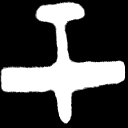

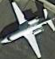

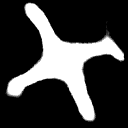

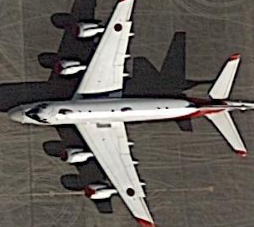

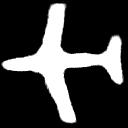

In [ ]:
'''
# Visualize 3 sample outputs
# TODO: approx 5 lines
'''
from google.colab.patches import cv2_imshow
data_dirs = '{}/data/test'.format(BASE_DIR)

meta_data = MetadataCatalog.get("data_detection_test")
dataset =  DatasetCatalog.get("data_detection_test")
#print(dataset)
for d in random.sample(dataset, 3):
  with torch.no_grad():
    img = cv2.imread(os.path.join(data_dirs,d["file_name"]))
    result = trainer(img)
    instances = result["instances"]
    scores = instances.scores
    max_confidence_index = scores.argmax()
    bbox = result["instances"].pred_boxes.tensor
    if len(bbox) == 0:
      print("NO Bounding Box is found !!!!!!")
      continue
    x1, y1, x2, y2 = map(int, bbox[max_confidence_index])
    obj_img = img[y1:y2, x1:x2]
    cv2_imshow(obj_img)
    img = cv2.resize(obj_img, (128, 128))
    img = img.astype(np.float32) / 255.0
    img = np.transpose(img, (2, 0, 1))
    img = np.expand_dims(img, axis=0)
    img = torch.from_numpy(img)
    img = img.cuda()
    pred = model(img)
    #print(pred[0][0].shape)
    output_image = pred[0][0].cpu().numpy() * 255
    #output_image = output_image.astype('uint8')
    cv2_imshow(output_image)

## Part 3: Instance Segmentation

In this part, you need to obtain the instance segmentation results for the test data by using the trained segmentation model in the previous part and the detection model in Part 1.

### Get Prediction

In [ ]:
'''
# Define a new function to obtain the prediction mask by passing a sample data
# For this part, you need to use all the previous parts (predictor, get_instance_sample, data preprocessings, etc)
# It is better to keep everything (as well as the output of this funcion) on gpu as tensors to speed up the operations.
# pred_mask is the instance segmentation result and should have different values for different planes.
# TODO: approx 35 lines
'''

def get_prediction_mask(data):

  return img, gt_mask, pred_mask # gt_mask could be all zero when the ground truth is not given.


### Visualization and Submission

In [ ]:
'''
# Visualise the output prediction as well as the GT Mask and Input image for a sample input
# TODO: approx 10 lines
'''



In [ ]:
'''
# ref: https://www.kaggle.com/rakhlin/fast-run-length-encoding-python
# https://www.kaggle.com/c/airbus-ship-detection/overview/evaluation
'''
def rle_encoding(x):
    '''
    x: pytorch tensor on gpu, 1 - mask, 0 - background
    Returns run length as list
    '''
    dots = torch.where(torch.flatten(x.long())==1)[0]
    if(len(dots)==0):
      return []
    inds = torch.where(dots[1:]!=dots[:-1]+1)[0]+1
    inds = torch.cat((torch.tensor([0], device=torch.device('cuda'), dtype=torch.long), inds))
    tmpdots = dots[inds]
    inds = torch.cat((inds, torch.tensor([len(dots)], device=torch.device('cuda'))))
    inds = inds[1:] - inds[:-1]
    runs = torch.cat((tmpdots, inds)).reshape((2,-1))
    runs = torch.flatten(torch.transpose(runs, 0, 1)).cpu().data.numpy()
    return ' '.join([str(i) for i in runs])

In [ ]:
'''
# You need to upload the csv file on kaggle
# The speed of your code in the previous parts highly affects the running time of this part
'''

preddic = {"ImageId": [], "EncodedPixels": []}

'''
# Writing the predictions of the training set
'''
my_data_list = DatasetCatalog.get("data_detection_{}".format('train'))
for i in tqdm(range(len(my_data_list)), position=0, leave=True):
  sample = my_data_list[i]
  sample['image_id'] = sample['file_name'].split("/")[-1][:-4]
  img, true_mask, pred_mask = get_prediction_mask(sample)
  inds = torch.unique(pred_mask)
  if(len(inds)==1):
    preddic['ImageId'].append(sample['image_id'])
    preddic['EncodedPixels'].append([])
  else:
    for index in inds:
      if(index == 0):
        continue
      tmp_mask = (pred_mask==index)
      encPix = rle_encoding(tmp_mask)
      preddic['ImageId'].append(sample['image_id'])
      preddic['EncodedPixels'].append(encPix)

'''
# Writing the predictions of the test set
'''

my_data_list = DatasetCatalog.get("data_detection_{}".format('test'))
for i in tqdm(range(len(my_data_list)), position=0, leave=True):
  sample = my_data_list[i]
  sample['image_id'] = sample['file_name'].split("/")[-1][:-4]
  img, true_mask, pred_mask = get_prediction_mask(sample)
  inds = torch.unique(pred_mask)
  if(len(inds)==1):
    preddic['ImageId'].append(sample['image_id'])
    preddic['EncodedPixels'].append([])
  else:
    for j, index in enumerate(inds):
      if(index == 0):
        continue
      tmp_mask = (pred_mask==index).double()
      encPix = rle_encoding(tmp_mask)
      preddic['ImageId'].append(sample['image_id'])
      preddic['EncodedPixels'].append(encPix)

pred_file = open("{}/pred.csv".format(BASE_DIR), 'w')
pd.DataFrame(preddic).to_csv(pred_file, index=False)
pred_file.close()


## Part 4: Mask R-CNN

For this part you need to follow a same procedure to part 2 with the configs of Mask R-CNN, other parts are generally the same as part 2.

### Data Loader

### Network

### Training

### Evaluation and Visualization